In [ ]:
# Part of the code is based on: https://dzone.com/articles/extending-q-learning-with-dyna-q#:~:text=Update%20Rule%20%2D%20Q%2Dvalues%20are,the%20importance%20of%20future%20rewards}

In [1]:
import gym
import numpy as np
import random
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from hyperopt import fmin, tpe, hp

In [2]:
env = gym.make('Blackjack-v1')

In [12]:
def initialize_q_values(env):
    nA = env.action_space.n
    return defaultdict(lambda: np.zeros(nA))


def get_action(state, q_values, epsilon):
    if np.random.random() < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(q_values[state])
    return action


def update(state, action, reward, next_state, q_values, lr, gamma, done):
    old_q_value = q_values[state][action]
    max_future_q = np.max(q_values[next_state])
    target = reward + lr * (gamma * max_future_q) * (1 - done)
    q_values[state][action] = (1 - lr) * old_q_value + lr * target
    
    
def decay_epsilon(epsilon, epsilon_decay):
    return epsilon -= epsilon_decay


In [21]:
def train_dynaq(n_episodes, epsilon, lr, gamma, planning_steps):
    q_values = initialize_q_values(env)
    epsilon_decay = epsilon / n_episodes
    model = defaultdict(dict)
    stats = []
    
    win = 0
#     loss = 0
#     total_reward = 0

    for episode in range(n_episodes):
        state = env.reset()[0]
        done = False

        while not done:
            action = get_action(state, q_values, epsilon)
            next_state, reward, done, _, _ = env.step(action)
            update(state, action, reward, next_state, q_values, lr, gamma, done)
            model[state][action] = (reward, next_state, done)

            for _ in range(planning_steps):
                random_state, actions = random.choice(list(model.items()))
                random_action = random.choice(list(actions))
                sample_reward, sample_next_state, _ = model[random_state][random_action]
                update(random_state, random_action, sample_reward, sample_next_state, q_values, lr, gamma, False)

            state = next_state

            if reward >= 1:
                win += 1
#             elif reward == -1:
#                 loss += 1

#             total_reward += reward
            
            winrates = (win/(episode + 1))*100
            
            stats.append([episode, winrates])

#     df = pd.DataFrame(stats, columns=['Episode', 'WinRates'])
#     df.to_csv("dynaq_stats", index=False)

    winrate = win / n_episodes
#     lossrate = loss / n_episodes
#     avg_reward = total_reward / n_episodes
    
    # Print or store the results as needed
#     print('Overall Win rate: {:.2f}%'.format(overall_winrate * 100))
#     print('Overall Loss rate: {:.2f}%'.format(overall_lossrate * 100))
#     print('Overall Average reward: {:.2f}'.format(overall_avg_reward))


    return q_values, winrate


In [22]:
num_episodes = 1_000_000
planning_steps = 50
epsilon = 0.5429690322794312
learning_rate = 0.0009218187326061286
gamma = 0.7682696531250257

q_values, winrate = train_dynaq(num_episodes, epsilon, learning_rate, gamma, planning_steps)


In [6]:
def test_policy(env, q_values, num_episodes):
    wins = 0
    losses = 0
    total_reward = 0  
    
    for _ in range(num_episodes):
        state = env.reset()[0]
        done = False
        episode_reward = 0  
        
        while not done:
            action = get_best_action(state, q_values)
            next_state, reward, done, _, _ = env.step(action)
            episode_reward += reward  
            state = next_state
            
    
        if reward >= 1.0:
            wins += 1
        elif reward == -1.0:
            losses += 1
        
        total_reward += episode_reward 
    
    win_rate = wins / num_episodes
    average_reward = total_reward / num_episodes 
    
    print(f"Tested on {num_episodes} episodes")
    print(f"Win rate: {win_rate * 100:.2f}%")
    print(f"Loss rate: {(losses / num_episodes) * 100:.2f}%")
    print(f"Average reward: {average_reward:.2f}")
    return win_rate, average_reward

In [7]:
def get_best_action(state, q_values):
    return np.argmax(q_values[state])

In [8]:
num_episodes = 1_000_000
win_rate = test_policy(env, q_values, num_episodes)

Tested on 1000000 episodes
Win rate: 42.66%
Loss rate: 48.72%
Average reward: -0.06


In [ ]:
# Part of the code for plotting the policy was used from: https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/

In [27]:
def create_grids(agent, use_ace):
    usable_ace = use_ace
    V = defaultdict(float)
    policy = defaultdict(int)

    for obs, action_values in agent.items():
        V[obs] = np.max(action_values)
        policy[obs] = np.argmax(action_values)

    X, Y = np.meshgrid(
        np.arange(12, 22),  # players count
        np.arange(1, 11))   # dealers face-up card

    Z = np.apply_along_axis(lambda obs: V[(obs[0], obs[1], usable_ace)], axis=2, arr=np.dstack([X, Y]))
    value_grid = X, Y, Z

    policy_grid = np.apply_along_axis(lambda obs: policy[(obs[0], obs[1], usable_ace)],
                                      axis=2, arr=np.dstack([X, Y]))
    
    return value_grid, policy_grid


def create_plots(policy_grid, titles):
    custom_cmap = LinearSegmentedColormap.from_list('custom', ["lightcoral", "white", "lightgreen"], N=256)

    fig, ax = plt.subplots(figsize=(8, 6))
    heatmap = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap=custom_cmap, cbar=False)
    heatmap.set_title('Policy: ' + titles)
    heatmap.set_xlabel("Player sum")
    heatmap.set_ylabel("Dealer card")
    heatmap.set_xticklabels(range(12, 22))
    heatmap.set_yticklabels(['A'] + list(range(2, 11)), fontsize=12)

    legend_elements = [Patch(facecolor='lightgreen', edgecolor='black', label='Hit'),
                       Patch(facecolor='lightcoral', edgecolor='black', label='Stick')]
    heatmap.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
#     plt.savefig("Dyna-Q " + titles)
    plt.show()

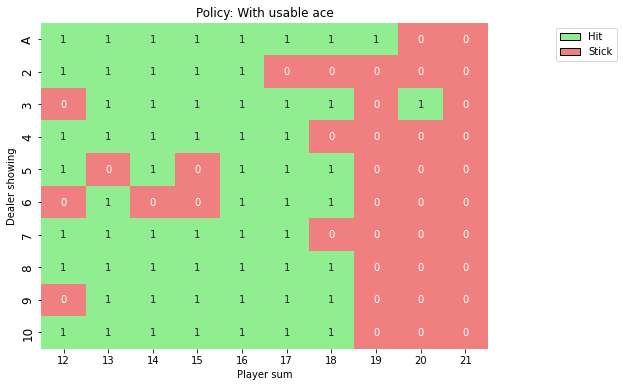

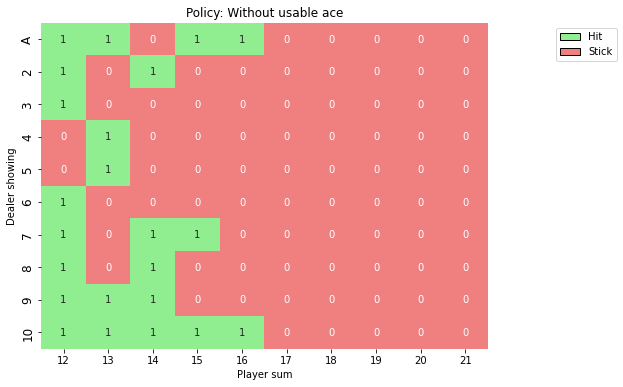

In [28]:
use_ace = True
value_grid, policy_grid = create_grids(q_values, use_ace)
create_plots(policy_grid, titles="With usable ace")

use_ace = False
value_grid, policy_grid = create_grids(q_values, use_ace)
create_plots(policy_grid, titles="Without usable ace")

In [9]:
def run_iterations(env, episodes, lr, epsilon, gamma, num_iterations):
    total_win = 0
    total_loss = 0
    total_reward = 0
    win_list = []

    for _ in range(num_iterations):
        win_rate = test_policy(env, q_values, episodes)
        total_win += win_rate[0]
#         total_loss += loss_rate
#         total_reward += avg_reward
        win_list.append(win_rate[0])
        print("{} of {} actions completed...".format(_ + 1, num_iterations))

    avg_win_rate = total_win / num_iterations
#     avg_loss_rate = total_loss / num_iterations
#     avg_total_reward = total_reward / num_iterations

    print('Average win rate: {:.2f}%'.format(avg_win_rate * 100))
#     print('Average loss rate: {:.2f}%'.format(avg_loss_rate * 100))
#     print('Average reward: {:.4f}'.format(avg_total_reward))
    print(win_list)

epsilon = 0.5429690322794312
lr = 0.0009218187326061286
gamma = 0.7682696531250257
episodes = 1_000_000
num_itterations = 10

run_iterations(env, episodes, lr, epsilon, gamma, num_itterations)


Tested on 1000000 episodes
Win rate: 42.63%
Loss rate: 48.77%
Average reward: -0.06
1 of 10 actions completed...
Tested on 1000000 episodes
Win rate: 42.62%
Loss rate: 48.74%
Average reward: -0.06
2 of 10 actions completed...
Tested on 1000000 episodes
Win rate: 42.64%
Loss rate: 48.76%
Average reward: -0.06
3 of 10 actions completed...
Tested on 1000000 episodes
Win rate: 42.62%
Loss rate: 48.78%
Average reward: -0.06
4 of 10 actions completed...
Tested on 1000000 episodes
Win rate: 42.64%
Loss rate: 48.70%
Average reward: -0.06
5 of 10 actions completed...
Tested on 1000000 episodes
Win rate: 42.63%
Loss rate: 48.69%
Average reward: -0.06
6 of 10 actions completed...
Tested on 1000000 episodes
Win rate: 42.68%
Loss rate: 48.73%
Average reward: -0.06
7 of 10 actions completed...
Tested on 1000000 episodes
Win rate: 42.68%
Loss rate: 48.73%
Average reward: -0.06
8 of 10 actions completed...
Tested on 1000000 episodes
Win rate: 42.62%
Loss rate: 48.77%
Average reward: -0.06
9 of 10 acti

In [ ]:
# [42.63, 42.62, 42.64, 42.62, 42.64, 42.63, 42.68, 42.68, 42.62, 42.68]